In [1]:
from scipy import io
import numpy as np
datas = io.loadmat("G:\Geophysical_Study\Graduation_thesis\EI.mat")
PI=np.array(datas['EI'])[-720:,-720:]
PI=np.transpose(PI,(1,0))
print(PI.shape)
print(PI.max(),PI.min())

(720, 720)
12533.714 2558.0408


In [2]:
#Zoeppritz equation
def poststack(inputdata):
    pi=inputdata*14000
    pi1=pi[:,:-1]; pi2=pi[:,1:]   
    dpi = pi2-pi1
    pi = (pi1+pi2)/2   
    syn=0.5 * dpi/pi
    return syn

import bruges as b
w, t = b.filters.ricker(0.2, 0.001, 30, return_t=True)  #main frequency=30Hz

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# def low_pass_filter(data, band_limit, sampling_rate):
#     cutoff_index = int(band_limit * data.shape[-1]/sampling_rate)#shape[-1]表示列数
#     F = torch.fft.rfft(data)
#     F[:,cutoff_index + 1:] = 0
#     return torch.fft.irfft(F).real

"""Filter the raw data"""
from scipy import signal        
b3, a3 = signal.butter(8, 0.1, 'lowpass')   #8 represents the degree of the filter
PIH= signal.filtfilt(b3, a3,PI)
# PIH=low_pass_filter(torch.tensor(PI),60,1000)
print('PIH',PIH.shape)
# PIH=torch.tensor(PI)

ela=PIH.squeeze()/14000   ##Compressed filtered signal
print('ela',ela.shape,ela.max(),ela.min())
syn=poststack(ela)       ##Syn is the data after the average difference
print('syn',syn.shape)

"""Convolutional operation on signals and the Rayleigh wavelet"""
from scipy import linalg as spla
def convmtx(h, n):
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return spla.toeplitz(col_1, row_1)[:, h.size//2:1-h.size//2]
G = convmtx(w, 719);
G = G/G.max();
G = torch.tensor(G)
print('G',G.shape)
syn=torch.tensor(syn)
syn=syn@G
print('syn',syn.shape)

PIH (720, 720)
ela (720, 720) 0.9759728282021274 0.1819990135228478
syn (720, 719)
G torch.Size([719, 720])
syn torch.Size([720, 720])


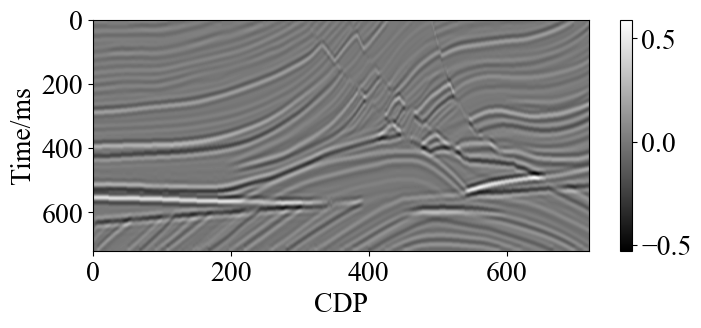

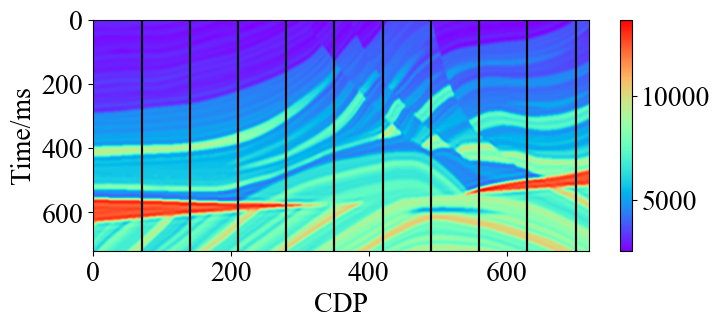

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family']=' Times New Roman, SimSun'#
plt.rcParams['mathtext.fontset'] = 'stix' #
plt.rcParams['font.size'] = 20
plt.figure(figsize=(8,3))
plt.imshow(syn.T,aspect='auto',cmap='gray')    
plt.ylim(720,0) 
plt.xlabel('CDP')
plt.ylabel('Time/ms')     
plt.colorbar()
plt.show()

plt.figure(figsize=(8,3))
plt.imshow(PIH.squeeze().T,aspect='auto',cmap='rainbow')  
plt.plot(np.ones(720)*(70),np.linspace(1,720,720),'black');plt.plot(np.ones(720)*(70),np.linspace(1,720,720),'black')   
plt.plot(np.ones(720)*(140),np.linspace(1,720,720),'black');plt.plot(np.ones(720)*(140),np.linspace(1,720,720),'black')  
plt.plot(np.ones(720)*(210),np.linspace(1,720,720),'black');plt.plot(np.ones(720)*(210),np.linspace(1,720,720),'black')   
plt.plot(np.ones(720)*(280),np.linspace(1,720,720),'black');plt.plot(np.ones(720)*(280),np.linspace(1,720,720),'black')  
plt.plot(np.ones(720)*(350),np.linspace(1,720,720),'black');plt.plot(np.ones(720)*(350),np.linspace(1,720,720),'black')  
plt.plot(np.ones(720)*(420),np.linspace(1,720,720),'black');plt.plot(np.ones(720)*(420),np.linspace(1,720,720),'black')  
plt.plot(np.ones(720)*(490),np.linspace(1,720,720),'black');plt.plot(np.ones(720)*(490),np.linspace(1,720,720),'black')  
plt.plot(np.ones(720)*(560),np.linspace(1,720,720),'black');plt.plot(np.ones(720)*(560),np.linspace(1,720,720),'black')
plt.plot(np.ones(720)*(630),np.linspace(1,720,720),'black');plt.plot(np.ones(720)*(630),np.linspace(1,720,720),'black')
plt.plot(np.ones(720)*(700),np.linspace(1,720,720),'black');plt.plot(np.ones(720)*(700),np.linspace(1,720,720),'black')
plt.ylim(720,0) 
plt.xlabel('CDP')
plt.ylabel('Time/ms')     
plt.colorbar()
plt.show()

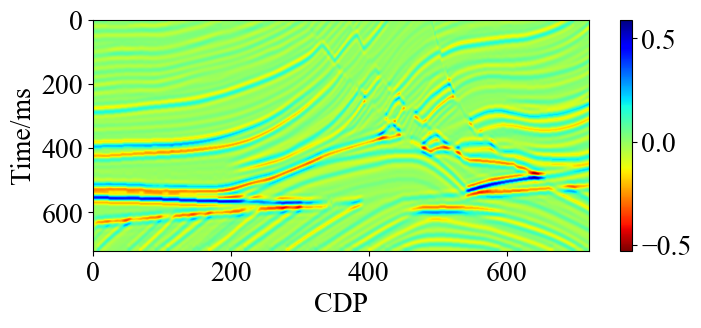

In [4]:
plt.rcParams['font.size'] = 20
plt.figure(figsize=(8,3))
plt.imshow(syn.T,aspect='auto',cmap='jet_r')    
plt.ylim(720,0) 
plt.xlabel('CDP')
plt.ylabel('Time/ms')     
plt.colorbar()
plt.savefig("raw_marmousi_seg.svg", dpi=300,format="svg")
plt.show()

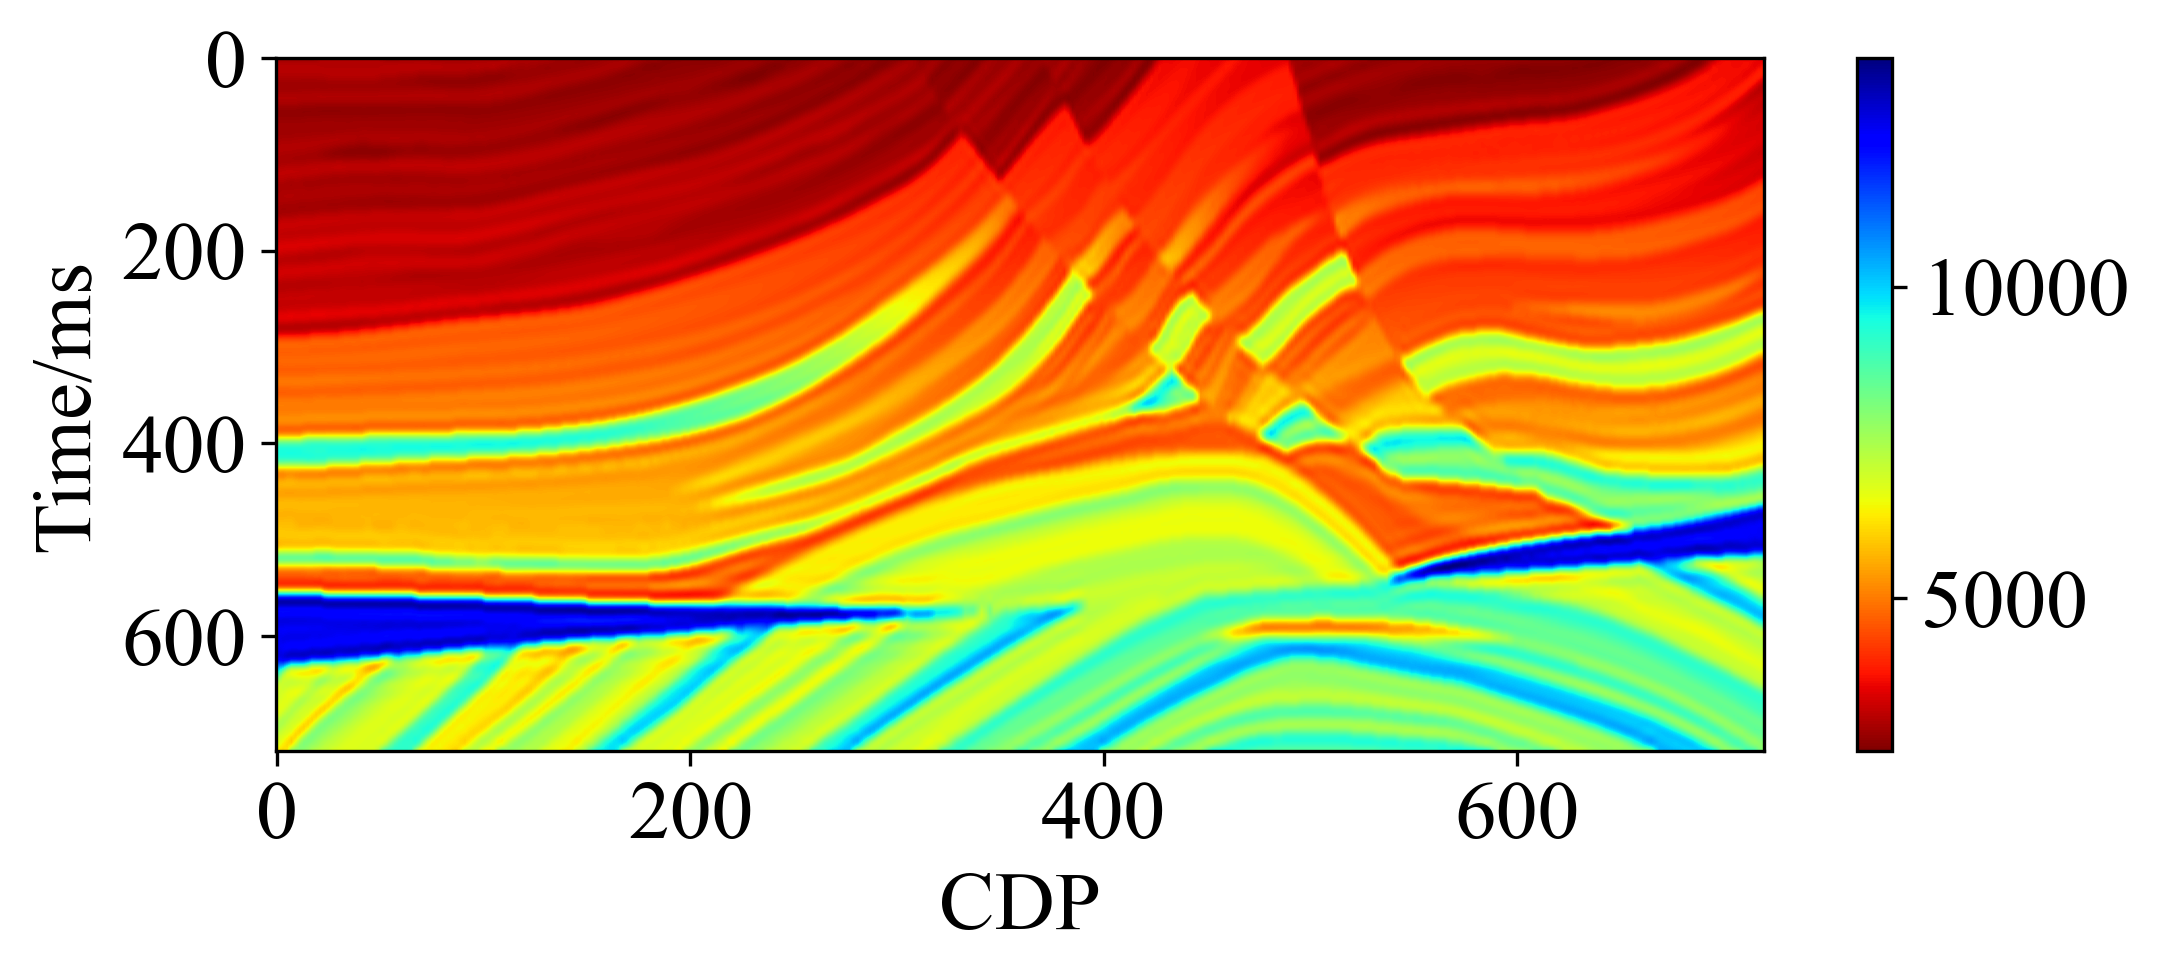

In [5]:
plt.rcParams['font.size'] = 20
plt.figure(figsize=(8,3),dpi=300)
plt.imshow(PIH.squeeze().T,aspect='auto',cmap='jet_r')    
plt.ylim(720,0) 
plt.xlabel('CDP')
plt.ylabel('Time/ms')     
plt.colorbar()
plt.show()

In [6]:
"""Single-supervised inversion network"""
import torch
import torch.nn as nn
import torch.optim as optim

"""Batch normalization and relu activation function increase nonlinearity and training stability"""
class batchnorm_relu(nn.Module):   
    def __init__(self, in_c):
        super().__init__()

        self.bn = nn.BatchNorm1d(in_c)  
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        return x
    
"""residual_block： build a deep network to reduce gradient vanishing"""    
class residual_block(nn.Module):   
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()

        """ Convolutional layer """
        self.b1 = batchnorm_relu(in_c)
        self.c1 = nn.Conv1d(in_c, out_c, kernel_size=21, padding=10, stride=stride)  # 修改为1D卷积层
        self.b2 = batchnorm_relu(out_c)
        self.c2 = nn.Conv1d(out_c, out_c, kernel_size=1, padding=0, stride=1)

        """ Shortcut Connection (Identity Mapping) """
        self.s = nn.Conv1d(in_c, out_c, kernel_size=1, padding=0, stride=stride)
    def forward(self, inputs):
        x = self.b1(inputs)
        x = self.c1(x)
        x = self.b2(x)
        x = self.c2(x)
        s = self.s(inputs)

        skip = x + s
        return skip

"""Decoding block definition: (one upsampling and residual block) feature decoding, combined with encoder skip link to restore high-resolution features"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=1, mode="linear", align_corners=True)  # 修改为1D上采样层
        self.r = residual_block(in_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        # print("x size:", x.size())
        # print("skip size:", skip.size())

        x = torch.cat([x, skip], axis=1)
        x = self.r(x)
        return x
    
"""The main part of the inversion model: encoder, bridge part, and decoder part """    
class inverse_model(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder 1 """
        self.c11 = nn.Conv1d(1, 10, kernel_size=21, padding=10)
        self.br1 = batchnorm_relu(10)
        self.c12 = nn.Conv1d(10, 10, kernel_size=21, padding=10)
        self.c13 = nn.Conv1d(1, 10, kernel_size=1, padding=0)

        """ Encoder 2 and 3 """
        self.r2 = residual_block(10, 32, stride=1)

        """ Bridge """
        self.r4 = residual_block(32, 64, stride=1)

        """ Decoder-Vp """
        self.d2vp = decoder_block(64, 32)
        self.d3vp = decoder_block(32, 10)

        """ Output """
        self.outputvp = nn.Conv1d(10, 1, kernel_size=1, padding=0)
 
        self.sigmoid = nn.Sigmoid()
        self.dp = nn.Dropout(0.2)

        # Initialize model parameters
        self.apply(self.init_weights)

        self.optimizer = optim.Adam(self.parameters(), 0.005, weight_decay=1e-4)  

    def init_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.xavier_normal_(m.weight)

    def forward(self, inputs):  
        ##Forward propagation path

        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)

        """ Bridge """
        b = self.r4(skip2)

        """ Decoder-vp """
        d2vp = self.d2vp(b, skip2)
        d3vp = self.d3vp(d2vp, skip1)
        """ output """
        outputvp = self.outputvp(d3vp)

        return torch.sigmoid(outputvp)


if __name__ == "__main__":
    inputs = torch.randn((7, 1, 720))   ##Create a random input data
    model = inverse_model()    
    y = model(inputs)       
    print(y.shape)


torch.Size([7, 1, 720])


In [7]:
my_net=inverse_model()
my_net

inverse_model(
  (c11): Conv1d(1, 10, kernel_size=(21,), stride=(1,), padding=(10,))
  (br1): batchnorm_relu(
    (bn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (c12): Conv1d(10, 10, kernel_size=(21,), stride=(1,), padding=(10,))
  (c13): Conv1d(1, 10, kernel_size=(1,), stride=(1,))
  (r2): residual_block(
    (b1): batchnorm_relu(
      (bn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (c1): Conv1d(10, 32, kernel_size=(21,), stride=(1,), padding=(10,))
    (b2): batchnorm_relu(
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (c2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (s): Conv1d(10, 32, kernel_size=(1,), stride=(1,))
  )
  (r4): residual_block(
    (b1): batchnorm_relu(
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re

In [8]:
PIH=torch.tensor(PIH.copy())
print(PIH.shape,syn.shape)

torch.Size([720, 720]) torch.Size([720, 720])


In [9]:
from torch.utils import data 
batch_size = 1
workers = 2
# PIL= signal.filtfilt(b3, a3,ela)
syn1=(syn-syn.min())/(syn.max()-syn.min())
PIH1=(PIH-PIH.min())/(PIH.max()-PIH.min())
dataloader1 = data.DataLoader(data.TensorDataset(syn1[[59,89,119,149,179,209,239,269
                                                      ,299,329,359,389,419,449,479,
                                                      509,539,569,599,629],:],
                                                PIH1[[59,89,119,149,179,209,239,269
                                                      ,299,329,359,389,419,449,479,
                                                      509,539,569,599,629],:]),
                            batch_size=batch_size,shuffle=False,num_workers=workers)
dataloader2 = data.DataLoader(data.TensorDataset(syn1[[659,689],:],
                                                PIH1[[659,689],:]),
                            batch_size=batch_size,shuffle=False,num_workers=workers)
for x_train,x_label in dataloader1:
    print(x_train.shape,x_label.shape)

torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])


In [10]:
"""Divide training and validation sets"""
for y_val,y_label in dataloader2:
    print(y_val.shape,y_label.shape)

torch.Size([1, 720]) torch.Size([1, 720])
torch.Size([1, 720]) torch.Size([1, 720])


In [11]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 50%|████████████████████████████████████████                                        | 100/200 [02:57<02:52,  1.73s/it]

Epoch: 100, Loss1:0.00222
Epoch: 100, Loss2:0.00374


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:59<00:00,  1.80s/it]

Epoch: 200, Loss1:0.00108
Epoch: 200, Loss2:0.00195


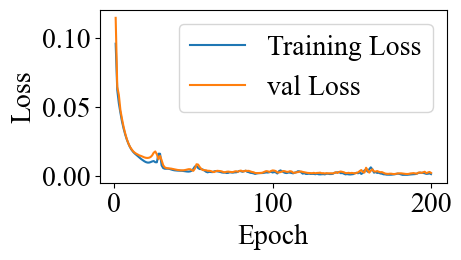

In [12]:
"""Single-supervised inversion network training"""

import os
import random
def seed_it(seed):
    random.seed(seed) 
    os.environ["PYTHONSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = True 
    torch.backends.cudnn.enabled = True  
    torch.manual_seed(seed)
seed_it(1314)

# device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

inverse_net= inverse_model().to(device)   #
criterion = nn.L1Loss()     
lr = 1e-4
epochs = 200
optimizer = torch.optim.AdamW(inverse_net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
Time=np.linspace(1,200,200)    
Loss1 = []
Loss2 = []
from tqdm import tqdm   
for epoch in tqdm(range(0, epochs)):
    inverse_net.train()      
    ela_pre = []    
    sei=[]      ##prediction value
    real=[]      ##real value
    for x_train,x_label in dataloader1:           
        optimizer.zero_grad()           
        x_train=x_train.to(device).float()
        x_label=x_label.to(device).float()
        
        
        pre1=inverse_net(x_train.unsqueeze(0))
        loss1=criterion(pre1,x_label.unsqueeze(0))      
        loss1 += loss1
        loss1.backward()    
        optimizer.step()   
    Loss1.append(loss1.detach().clone().item())        
    for y_val,y_label in dataloader2:  
        optimizer.zero_grad()
        y_val=y_val.to(device).float()
        y_label=y_label.to(device).float()
        
        
        pre2=inverse_net(y_val.unsqueeze(0))
        loss2=criterion(pre2,y_label.unsqueeze(0))
        loss2 += loss2
        loss2.backward()
        optimizer.step()
    Loss2.append(loss2.detach().clone().item())
    if (epoch+1)%100 == 0:    
        
        print('Epoch: {}, Loss1:{:.5f}'
              .format(epoch+1,loss1.item()))
        print('Epoch: {}, Loss2:{:.5f}'
              .format(epoch+1,loss2.item()))


plt.figure(figsize=(5,3))
plt.plot(range(1,len(Loss1)+1),Loss1, label='Training Loss')
plt.plot(range(1,len(Loss2)+1),Loss2, label='val Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.tight_layout() 
plt.show()

In [13]:
"""Predict syn1 and obtain the result pre_ Test"""
pre_test=inverse_net(syn1.unsqueeze(1).float().to(device)).detach().cpu().squeeze()
print(pre_test.shape)

torch.Size([720, 720])


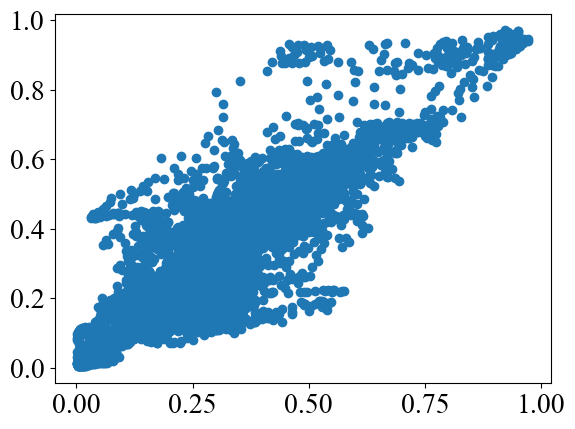

In [14]:
##Draw the Scatter plot of pre_test and PIH1

plt.scatter(pre_test[[70,140,210,280,350,420,490,560,630,700]].reshape(-1,1),PIH1[[70,140,210,280,350,420,490,560,630,700]].reshape(-1,1))

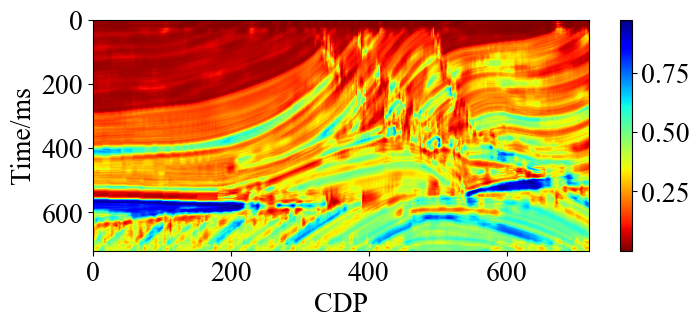

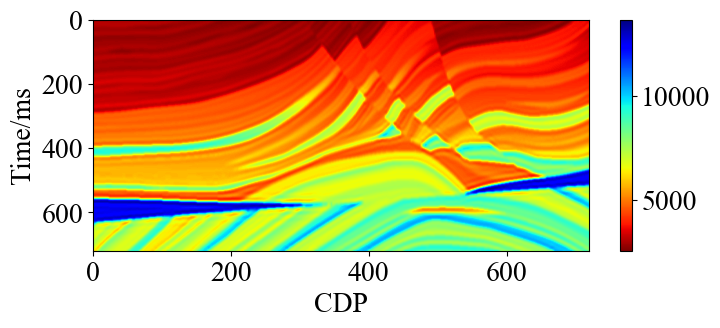

In [15]:
plt.figure(figsize=(8,3))
plt.imshow(pre_test.T#,vmin=PIH1.min(),vmax=PIH1.max()
,aspect='auto',cmap='jet_r')
plt.ylim(720,0)
plt.xlabel('CDP')
plt.ylabel('Time/ms') 
plt.colorbar()
# plt.savefig("pre_test.T.svg", dpi=300,format="svg")
plt.show()
#
plt.figure(figsize=(8,3))
plt.imshow(PIH.T#,vmin=PIH1.min(),vmax=PIH1.max()
,aspect='auto',cmap='jet_r') 
plt.ylim(720,0)
plt.xlabel('CDP')
plt.ylabel('Time/ms') 
plt.colorbar()
plt.show()

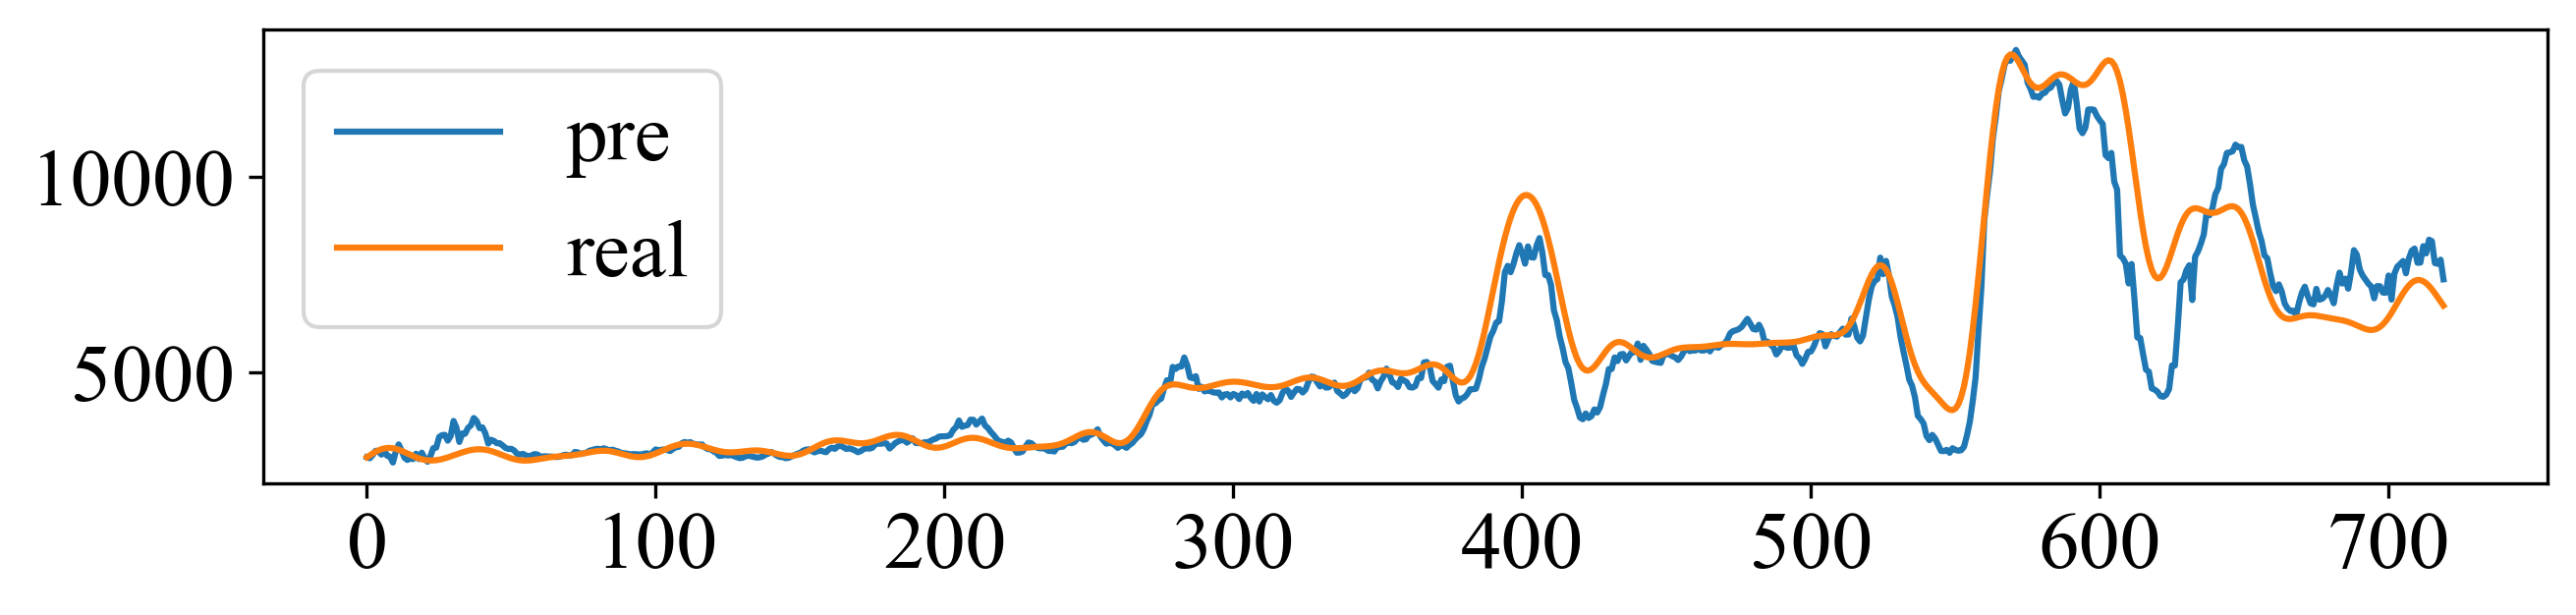

In [16]:

pre_test=pre_test*(PIH.max()-PIH.min())+PIH.min()
plt.figure(figsize=(10,2),dpi=300)
plt.plot(pre_test[99,:])
plt.plot(PIH[99,:])
plt.legend(['pre','real'])
plt.show()

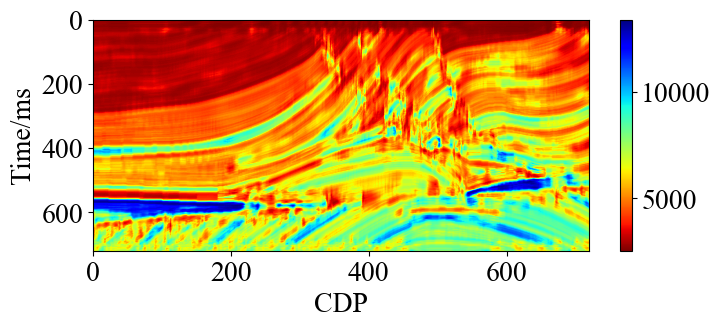

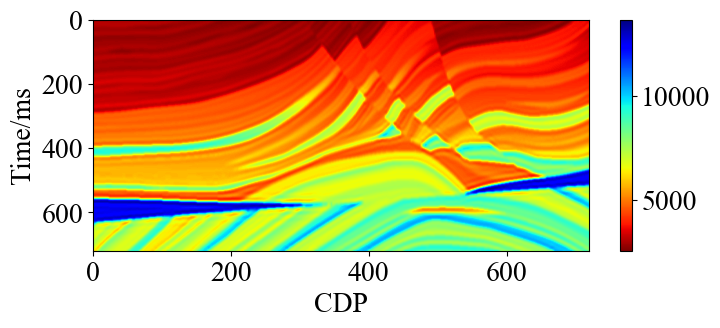

In [17]:
plt.figure(figsize=(8,3))
plt.imshow(pre_test.T#,vmin=PIH1.min(),vmax=PIH1.max()
,aspect='auto',cmap='jet_r')
plt.ylim(720,0)
plt.xlabel('CDP')
plt.ylabel('Time/ms') 
plt.colorbar()
plt.savefig("pre_test.T.svg", dpi=300,format="svg")
plt.show()
#
plt.figure(figsize=(8,3))
plt.imshow(PIH.T#,vmin=PIH1.min(),vmax=PIH1.max()
,aspect='auto',cmap='jet_r')
plt.ylim(720,0)
plt.xlabel('CDP')
plt.ylabel('Time/ms') 
plt.colorbar()
plt.savefig("PIH.T.svg", dpi=300,format="svg")
plt.show()

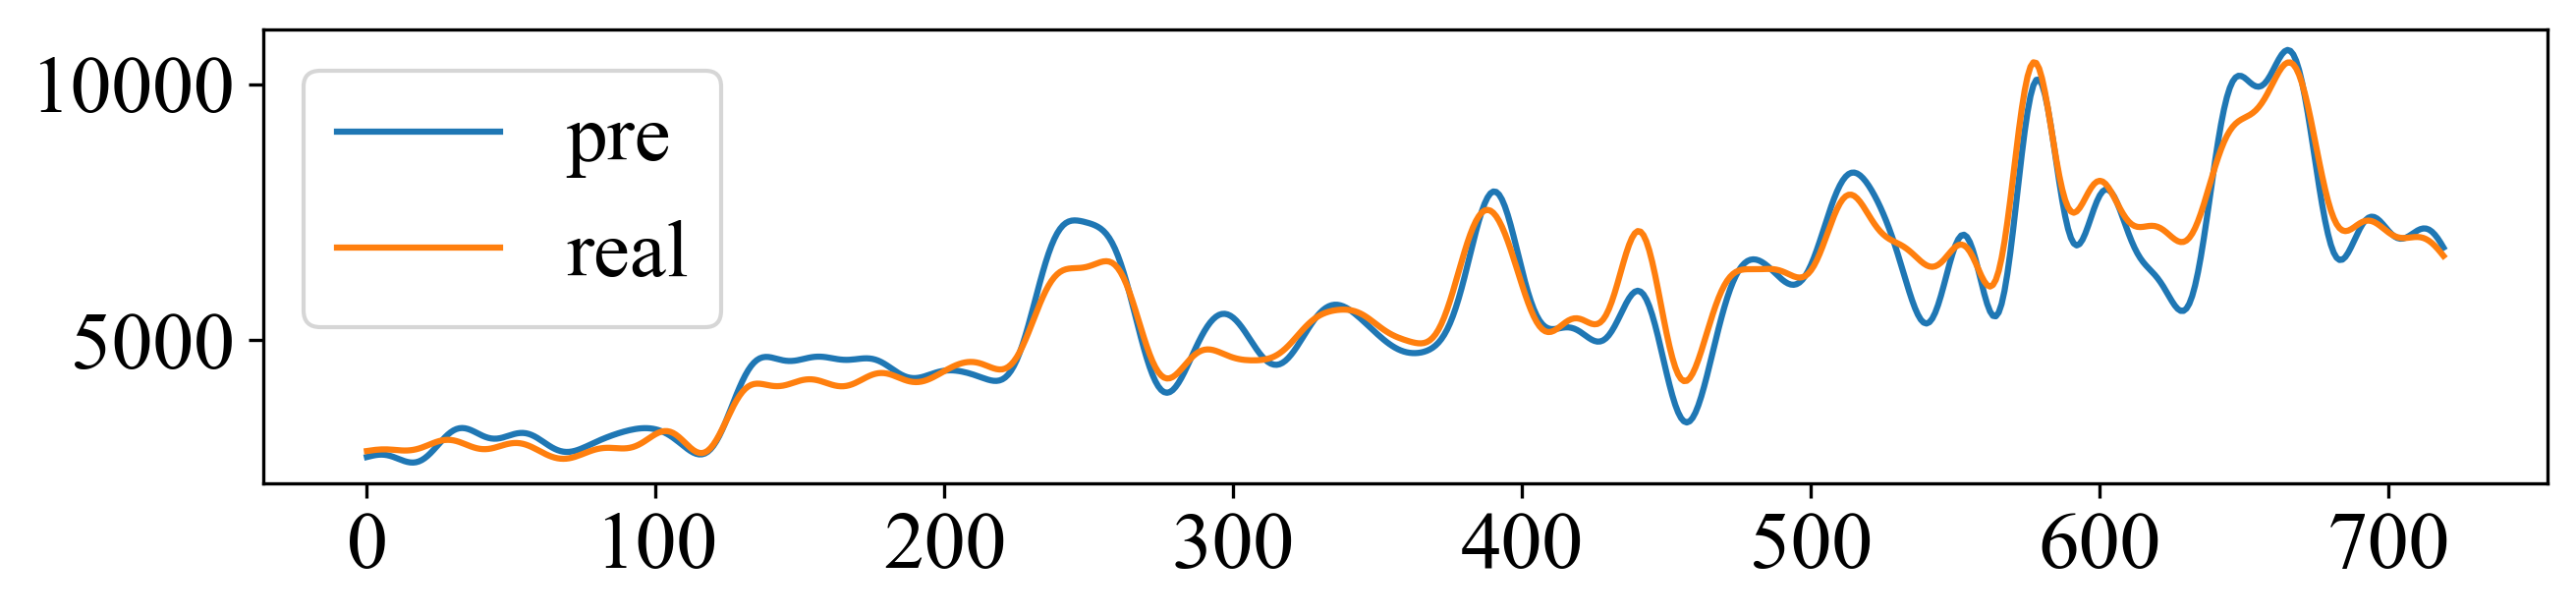

In [18]:
plt.figure(figsize=(10,2),dpi=300)
pre_test309= signal.filtfilt(b3, a3,pre_test[309,:])
plt.plot(pre_test309)
plt.plot(PIH[309,:])
plt.legend(['pre','real'])
plt.show()

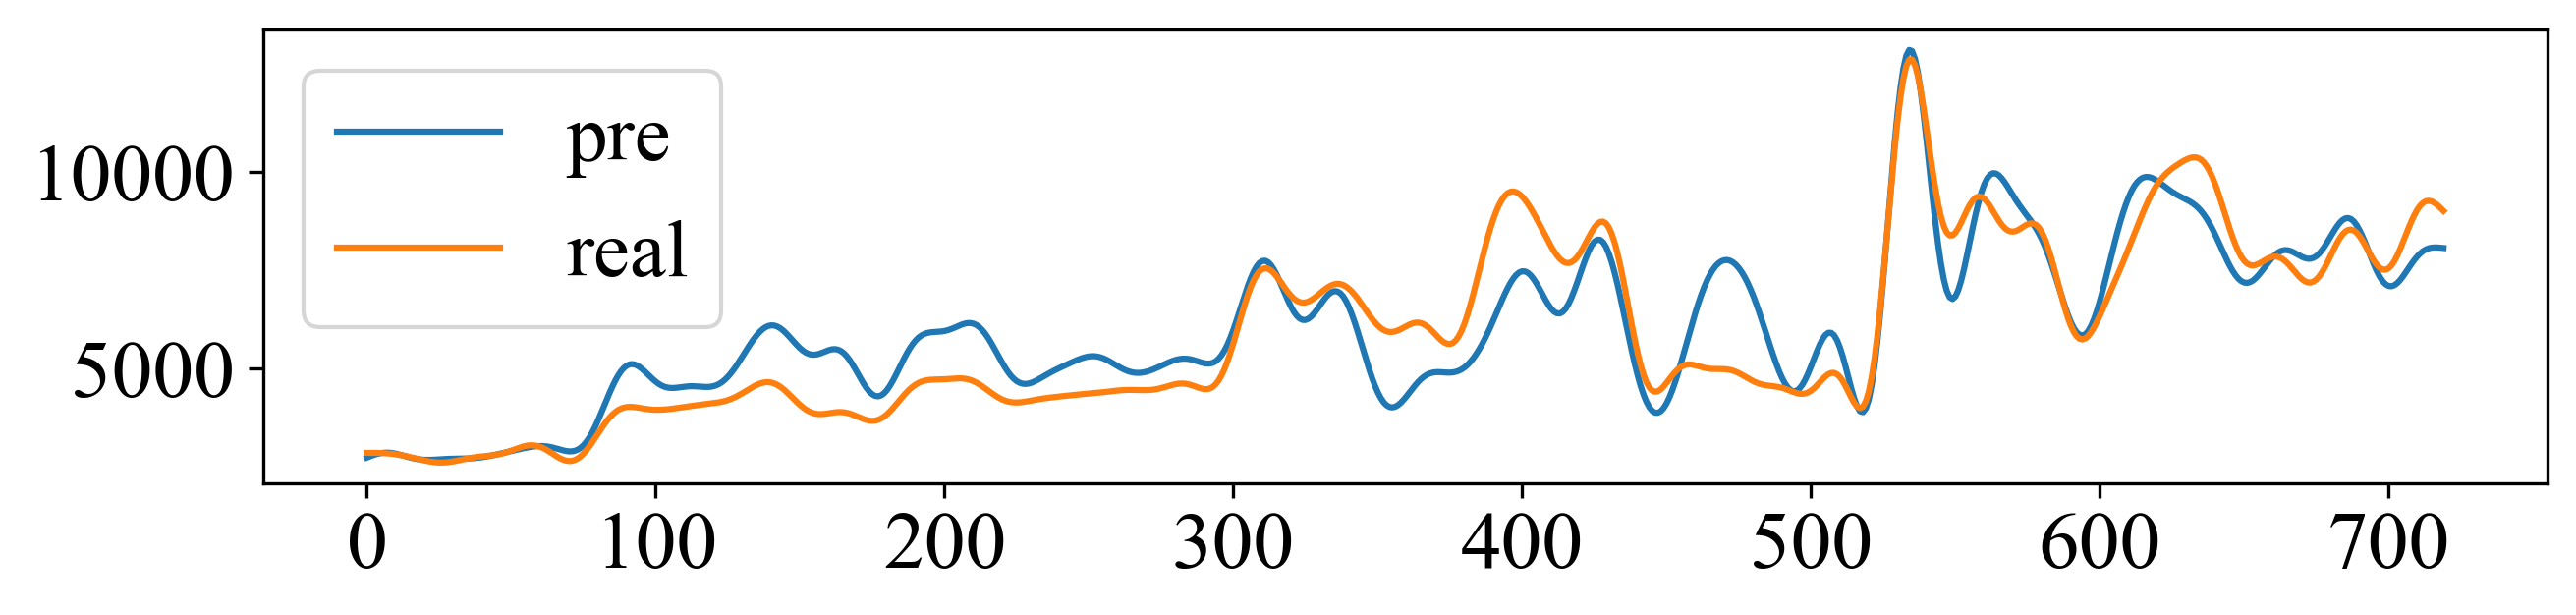

In [19]:
plt.figure(figsize=(10,2),dpi=300)
pre_test554= signal.filtfilt(b3, a3,pre_test[554,:])
plt.plot(pre_test554)
plt.plot(PIH[554,:])
plt.legend(['pre','real'])
plt.show()

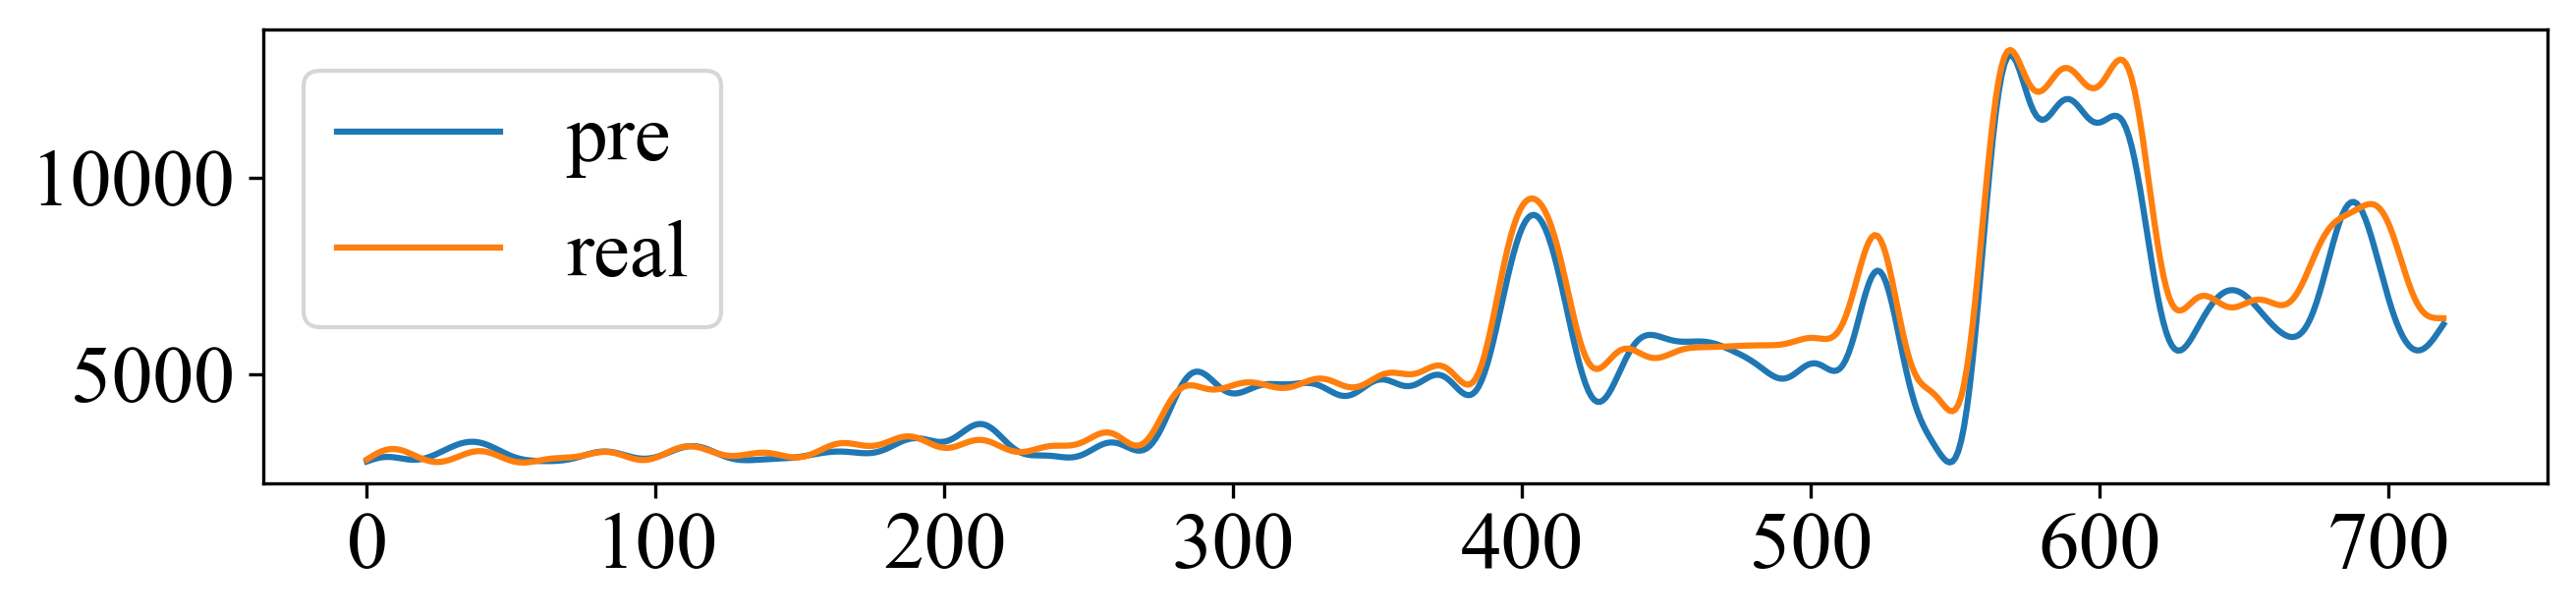

In [20]:
plt.figure(figsize=(10,2),dpi=300)
pre_test74= signal.filtfilt(b3, a3,pre_test[74,:])
plt.plot(pre_test74)
plt.plot(PIH[74,:])
plt.legend(['pre','real'])
plt.show()

In [21]:
#Defining the forward Network
class Forward(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Forward, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.for_res=nn.Sequential(nn.Conv1d(n_classes, n_classes, kernel_size=21, padding=10),
                                    nn.BatchNorm1d(n_classes),
                                    nn.Tanh())
        self.for_conv=nn.Sequential(nn.ConvTranspose1d(n_classes, n_classes, kernel_size=21, padding=10),
                                    nn.BatchNorm1d(n_classes),
                                    nn.Tanh())
        
    def forward(self, x):        
        
        res=self.for_res(x)         
        syn=self.for_conv(res)      
        #print('syn',syn.shape)
        
        return syn

if __name__ == '__main__':
    inputs2 = torch.randn((1, 1, 720))  #random input
    forward_net = Forward(n_channels=1, n_classes=1)
    y = forward_net(inputs2)
    print(y.shape)
    print(forward_net)

torch.Size([1, 1, 720])
Forward(
  (for_res): Sequential(
    (0): Conv1d(1, 1, kernel_size=(21,), stride=(1,), padding=(10,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (for_conv): Sequential(
    (0): ConvTranspose1d(1, 1, kernel_size=(21,), stride=(1,), padding=(10,))
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
)


In [22]:
"""Take one seismic trace every 20 traces to obtain unlabeled data"""

AT_nolabel=syn1[:,::20].reshape(1,1,-1)

print(AT_nolabel.shape)

torch.Size([1, 1, 25920])


epoch 0 Loss/train 0.3092880845069885 val_loss 0.14878283441066742
epoch 0 Loss/train 0.23566900193691254 val_loss 0.10893548280000687
epoch 0 Loss/train 0.20848989486694336 val_loss 0.11529482156038284
epoch 0 Loss/train 0.18470165133476257 val_loss 0.12215676158666611
epoch 0 Loss/train 0.1777772158384323 val_loss 0.13105593621730804
epoch 0 Loss/train 0.17691084742546082 val_loss 0.13801081478595734
epoch 0 Loss/train 0.18424314260482788 val_loss 0.1474618911743164
epoch 0 Loss/train 0.18878161907196045 val_loss 0.15712861716747284
epoch 0 Loss/train 0.1918056756258011 val_loss 0.16054292023181915
epoch 0 Loss/train 0.192177876830101 val_loss 0.16167861223220825
epoch 0 Loss/train 0.1933809071779251 val_loss 0.162697896361351
epoch 0 Loss/train 0.18895204365253448 val_loss 0.16332116723060608
epoch 0 Loss/train 0.19114655256271362 val_loss 0.16350166499614716
epoch 0 Loss/train 0.1992006152868271 val_loss 0.16340336203575134
epoch 0 Loss/train 0.2083432972431183 val_loss 0.163284629

epoch 6 Loss/train 0.0449063703417778 val_loss 0.07017184793949127
epoch 6 Loss/train 0.04942353442311287 val_loss 0.07328212261199951
epoch 6 Loss/train 0.04782629758119583 val_loss 0.07656101137399673
epoch 6 Loss/train 0.04763728380203247 val_loss 0.07860392332077026
epoch 6 Loss/train 0.04639663174748421 val_loss 0.07865797728300095
epoch 6 Loss/train 0.047977130860090256 val_loss 0.0760902538895607
epoch 6 Loss/train 0.050922978669404984 val_loss 0.07502645254135132
epoch 6 Loss/train 0.05597110837697983 val_loss 0.07403407990932465
epoch 6 Loss/train 0.05692475289106369 val_loss 0.07347659021615982
epoch 6 Loss/train 0.05544117093086243 val_loss 0.07450490444898605
epoch 6 Loss/train 0.0637001171708107 val_loss 0.07478711754083633
epoch 6 Loss/train 0.06198881193995476 val_loss 0.07571568340063095
epoch 6 Loss/train 0.0557139590382576 val_loss 0.07746586948633194
epoch 6 Loss/train 0.046103835105895996 val_loss 0.07451006770133972
epoch 6 Loss/train 0.046428993344306946 val_loss 

epoch 12 Loss/train 0.02050936408340931 val_loss 0.04440637305378914
epoch 12 Loss/train 0.022507261484861374 val_loss 0.04669153690338135
epoch 12 Loss/train 0.019200429320335388 val_loss 0.04940745607018471
epoch 12 Loss/train 0.02093465067446232 val_loss 0.05252958461642265
epoch 12 Loss/train 0.021713266149163246 val_loss 0.055837687104940414
epoch 12 Loss/train 0.02316712960600853 val_loss 0.058791693300008774
epoch 12 Loss/train 0.020332621410489082 val_loss 0.06076473370194435
epoch 12 Loss/train 0.027170991525053978 val_loss 0.061192404478788376
epoch 12 Loss/train 0.02796049416065216 val_loss 0.05972157046198845
epoch 12 Loss/train 0.02302897907793522 val_loss 0.056600626558065414
epoch 12 Loss/train 0.028233077377080917 val_loss 0.05306965485215187
epoch 12 Loss/train 0.02562166191637516 val_loss 0.051092248409986496
epoch 12 Loss/train 0.026599420234560966 val_loss 0.05184129253029823
epoch 12 Loss/train 0.020560838282108307 val_loss 0.049926482141017914
epoch 12 Loss/train 

epoch 18 Loss/train 0.013776902109384537 val_loss 0.03177874907851219
epoch 18 Loss/train 0.013379806652665138 val_loss 0.03214756026864052
epoch 18 Loss/train 0.012143880128860474 val_loss 0.03209643438458443
epoch 18 Loss/train 0.010742980986833572 val_loss 0.03233148902654648
epoch 18 Loss/train 0.010140744969248772 val_loss 0.033303841948509216
epoch 18 Loss/train 0.01033046469092369 val_loss 0.03444652631878853
epoch 18 Loss/train 0.011089658364653587 val_loss 0.03589899465441704
epoch 18 Loss/train 0.01602851413190365 val_loss 0.037321336567401886
epoch 18 Loss/train 0.011600053869187832 val_loss 0.036645837128162384
epoch 18 Loss/train 0.011947643011808395 val_loss 0.03483140468597412
epoch 18 Loss/train 0.011277667246758938 val_loss 0.033554498106241226
epoch 18 Loss/train 0.011209522373974323 val_loss 0.03243674337863922
epoch 18 Loss/train 0.0159761980175972 val_loss 0.03153997287154198
epoch 18 Loss/train 0.01890011504292488 val_loss 0.030093170702457428
epoch 18 Loss/train 

epoch 23 Loss/train 0.011359813623130322 val_loss 0.02465871162712574
epoch 23 Loss/train 0.009796371683478355 val_loss 0.023222757503390312
epoch 23 Loss/train 0.010508745908737183 val_loss 0.021996883675456047
epoch 24 Loss/train 0.009366532787680626 val_loss 0.02132182940840721
epoch 24 Loss/train 0.008760398253798485 val_loss 0.021485300734639168
epoch 24 Loss/train 0.008373516611754894 val_loss 0.021761875599622726
epoch 24 Loss/train 0.008244490250945091 val_loss 0.021772878244519234
epoch 24 Loss/train 0.00796899851411581 val_loss 0.021943403407931328
epoch 24 Loss/train 0.007894130423665047 val_loss 0.022857695817947388
epoch 24 Loss/train 0.008860325440764427 val_loss 0.024716367945075035
epoch 24 Loss/train 0.00996829941868782 val_loss 0.027040159329771996
epoch 24 Loss/train 0.009058130905032158 val_loss 0.02900847978889942
epoch 24 Loss/train 0.009642270393669605 val_loss 0.0298388060182333
epoch 24 Loss/train 0.008769884705543518 val_loss 0.030387412756681442
epoch 24 Loss

epoch 29 Loss/train 0.011021850630640984 val_loss 0.026473263278603554
epoch 29 Loss/train 0.007687045726925135 val_loss 0.02443521097302437
epoch 29 Loss/train 0.006723469123244286 val_loss 0.022768264636397362
epoch 29 Loss/train 0.008381245657801628 val_loss 0.021596357226371765
epoch 29 Loss/train 0.009005277417600155 val_loss 0.020607396960258484
epoch 29 Loss/train 0.007651838473975658 val_loss 0.019823657348752022
epoch 30 Loss/train 0.007333680056035519 val_loss 0.019969183951616287
epoch 30 Loss/train 0.0074387784115970135 val_loss 0.021123001351952553
epoch 30 Loss/train 0.007477002218365669 val_loss 0.022814348340034485
epoch 30 Loss/train 0.008861048147082329 val_loss 0.024398338049650192
epoch 30 Loss/train 0.007697010412812233 val_loss 0.02526324987411499
epoch 30 Loss/train 0.006733589340001345 val_loss 0.02618250995874405
epoch 30 Loss/train 0.007970043458044529 val_loss 0.02717239037156105
epoch 30 Loss/train 0.009658380411565304 val_loss 0.028673304244875908
epoch 30 

epoch 35 Loss/train 0.007235580123960972 val_loss 0.03242650255560875
epoch 35 Loss/train 0.009929045103490353 val_loss 0.0320504792034626
epoch 35 Loss/train 0.010060075670480728 val_loss 0.03035617433488369
epoch 35 Loss/train 0.01050734892487526 val_loss 0.02837425097823143
epoch 35 Loss/train 0.007128218188881874 val_loss 0.024717260152101517
epoch 35 Loss/train 0.006552338134497404 val_loss 0.021375343203544617
epoch 35 Loss/train 0.008940880186855793 val_loss 0.019164666533470154
epoch 35 Loss/train 0.008079729042947292 val_loss 0.017831552773714066
epoch 35 Loss/train 0.008038539439439774 val_loss 0.017270512878894806
epoch 36 Loss/train 0.007806520443409681 val_loss 0.018441472202539444
epoch 36 Loss/train 0.007435471285134554 val_loss 0.02098529413342476
epoch 36 Loss/train 0.007720424327999353 val_loss 0.02384781837463379
epoch 36 Loss/train 0.007658391259610653 val_loss 0.02605612389743328
epoch 36 Loss/train 0.007004769053310156 val_loss 0.027359168976545334
epoch 36 Loss/t

epoch 41 Loss/train 0.007536774501204491 val_loss 0.025292782112956047
epoch 41 Loss/train 0.006264145020395517 val_loss 0.027857134118676186
epoch 41 Loss/train 0.0072860089130699635 val_loss 0.03154292330145836
epoch 41 Loss/train 0.006295891012996435 val_loss 0.03479418158531189
epoch 41 Loss/train 0.009252159856259823 val_loss 0.03701702877879143
epoch 41 Loss/train 0.009977869689464569 val_loss 0.03759513050317764
epoch 41 Loss/train 0.011312104761600494 val_loss 0.03649052977561951
epoch 41 Loss/train 0.007349915336817503 val_loss 0.03276343271136284
epoch 41 Loss/train 0.0070154075510799885 val_loss 0.02877507358789444
epoch 41 Loss/train 0.008308439515531063 val_loss 0.02509821392595768
epoch 41 Loss/train 0.006639354862272739 val_loss 0.02231566421687603
epoch 41 Loss/train 0.0068522910587489605 val_loss 0.020684722810983658
epoch 42 Loss/train 0.0078063164837658405 val_loss 0.020322278141975403
epoch 42 Loss/train 0.006570815108716488 val_loss 0.021011438220739365
epoch 42 Lo

epoch 47 Loss/train 0.006936003919690847 val_loss 0.02903709001839161
epoch 47 Loss/train 0.0070579820312559605 val_loss 0.02799355983734131
epoch 47 Loss/train 0.007898305542767048 val_loss 0.026737041771411896
epoch 47 Loss/train 0.006664793007075787 val_loss 0.0248873233795166
epoch 47 Loss/train 0.007328679785132408 val_loss 0.023706559091806412
epoch 47 Loss/train 0.0062299384735524654 val_loss 0.02304699271917343
epoch 47 Loss/train 0.006080992054194212 val_loss 0.023383887484669685
epoch 47 Loss/train 0.006394784897565842 val_loss 0.02416490577161312
epoch 47 Loss/train 0.008154118433594704 val_loss 0.025279533118009567
epoch 47 Loss/train 0.007450701668858528 val_loss 0.025921303778886795
epoch 47 Loss/train 0.009222463704645634 val_loss 0.02633017674088478
epoch 47 Loss/train 0.0076402886770665646 val_loss 0.02597142942249775
epoch 47 Loss/train 0.006884494796395302 val_loss 0.02587030455470085
epoch 47 Loss/train 0.00885946024209261 val_loss 0.02552751451730728
epoch 47 Loss/

epoch 53 Loss/train 0.0062611158937215805 val_loss 0.023382293060421944
epoch 53 Loss/train 0.005449277814477682 val_loss 0.0231728907674551
epoch 53 Loss/train 0.005763453897088766 val_loss 0.023150449618697166
epoch 53 Loss/train 0.005964312702417374 val_loss 0.023398632183670998
epoch 53 Loss/train 0.006023033056408167 val_loss 0.023901907727122307
epoch 53 Loss/train 0.006874751299619675 val_loss 0.024539588019251823
epoch 53 Loss/train 0.005919288378208876 val_loss 0.025365740060806274
epoch 53 Loss/train 0.005971310194581747 val_loss 0.02615872025489807
epoch 53 Loss/train 0.005311168264597654 val_loss 0.026649167761206627
epoch 53 Loss/train 0.005791785195469856 val_loss 0.02716723084449768
epoch 53 Loss/train 0.0063792564906179905 val_loss 0.027465280145406723
epoch 53 Loss/train 0.00593293271958828 val_loss 0.02679651975631714
epoch 53 Loss/train 0.00597555423155427 val_loss 0.026219867169857025
epoch 53 Loss/train 0.006947166286408901 val_loss 0.026071323081851006
epoch 53 Lo

epoch 58 Loss/train 0.005659402813762426 val_loss 0.01994537003338337
epoch 58 Loss/train 0.005152778699994087 val_loss 0.02027825266122818
epoch 58 Loss/train 0.005637560971081257 val_loss 0.020654994994401932
epoch 59 Loss/train 0.005680524278432131 val_loss 0.020943980664014816
epoch 59 Loss/train 0.0054187774658203125 val_loss 0.021085252985358238
epoch 59 Loss/train 0.0049871294759213924 val_loss 0.021122414618730545
epoch 59 Loss/train 0.005151224788278341 val_loss 0.021080080419778824
epoch 59 Loss/train 0.005256532225757837 val_loss 0.021088693290948868
epoch 59 Loss/train 0.0049333730712533 val_loss 0.02112959697842598
epoch 59 Loss/train 0.005352935288101435 val_loss 0.02117072604596615
epoch 59 Loss/train 0.004971636924892664 val_loss 0.021220119670033455
epoch 59 Loss/train 0.00542851397767663 val_loss 0.021229907870292664
epoch 59 Loss/train 0.005015289876610041 val_loss 0.02104341797530651
epoch 59 Loss/train 0.005120593588799238 val_loss 0.020781327039003372
epoch 59 Los

epoch 64 Loss/train 0.00544072175398469 val_loss 0.021696949377655983
epoch 64 Loss/train 0.005530626513063908 val_loss 0.021939558908343315
epoch 64 Loss/train 0.004669554065912962 val_loss 0.021960202604532242
epoch 64 Loss/train 0.004788932390511036 val_loss 0.021870939061045647
epoch 64 Loss/train 0.00518095213919878 val_loss 0.021627485752105713
epoch 64 Loss/train 0.00474264333024621 val_loss 0.021374912932515144
epoch 64 Loss/train 0.005057751666754484 val_loss 0.021021315827965736
epoch 65 Loss/train 0.005135944113135338 val_loss 0.020549200475215912
epoch 65 Loss/train 0.004961129277944565 val_loss 0.020081698894500732
epoch 65 Loss/train 0.004711491987109184 val_loss 0.019660821184515953
epoch 65 Loss/train 0.005078477784991264 val_loss 0.01934400387108326
epoch 65 Loss/train 0.005133186932653189 val_loss 0.019213901832699776
epoch 65 Loss/train 0.004815530963242054 val_loss 0.019153984263539314
epoch 65 Loss/train 0.004965602420270443 val_loss 0.019282327964901924
epoch 65 L

epoch 70 Loss/train 0.004513606894761324 val_loss 0.020634792745113373
epoch 70 Loss/train 0.004723806399852037 val_loss 0.020453501492738724
epoch 70 Loss/train 0.004377912729978561 val_loss 0.02024981938302517
epoch 70 Loss/train 0.004598697181791067 val_loss 0.020122669637203217
epoch 70 Loss/train 0.0050593591295182705 val_loss 0.020072538405656815
epoch 70 Loss/train 0.005038554314523935 val_loss 0.020124608650803566
epoch 70 Loss/train 0.004480025731027126 val_loss 0.02022646926343441
epoch 70 Loss/train 0.004452591761946678 val_loss 0.020423278212547302
epoch 70 Loss/train 0.00490071065723896 val_loss 0.020701022818684578
epoch 70 Loss/train 0.004492882639169693 val_loss 0.020943012088537216
epoch 70 Loss/train 0.0046171993017196655 val_loss 0.0210878886282444
epoch 71 Loss/train 0.004787434823811054 val_loss 0.021077774465084076
epoch 71 Loss/train 0.004852693993598223 val_loss 0.020985744893550873
epoch 71 Loss/train 0.004638460464775562 val_loss 0.020837215706706047
epoch 71 

epoch 76 Loss/train 0.004420788027346134 val_loss 0.0202045701444149
epoch 76 Loss/train 0.0045348964631557465 val_loss 0.0201669093221426
epoch 76 Loss/train 0.004668626002967358 val_loss 0.02002437599003315
epoch 76 Loss/train 0.004417469725012779 val_loss 0.019854819402098656
epoch 76 Loss/train 0.00470489589497447 val_loss 0.019806310534477234
epoch 76 Loss/train 0.004295410122722387 val_loss 0.019959213212132454
epoch 76 Loss/train 0.004368272144347429 val_loss 0.02004171349108219
epoch 76 Loss/train 0.004867440555244684 val_loss 0.020200248807668686
epoch 76 Loss/train 0.004992067813873291 val_loss 0.020271744579076767
epoch 76 Loss/train 0.004392433911561966 val_loss 0.020141083747148514
epoch 76 Loss/train 0.004258573055267334 val_loss 0.02001354657113552
epoch 76 Loss/train 0.004846107214689255 val_loss 0.019752303138375282
epoch 76 Loss/train 0.004500362556427717 val_loss 0.019479164853692055
epoch 76 Loss/train 0.004577585496008396 val_loss 0.01924051158130169
epoch 77 Loss/

epoch 82 Loss/train 0.0024031205102801323 val_loss 0.020386017858982086
epoch 82 Loss/train 0.0023789219558238983 val_loss 0.020300868898630142
epoch 82 Loss/train 0.002358088968321681 val_loss 0.020292110741138458
epoch 82 Loss/train 0.0021561398170888424 val_loss 0.020313994958996773
epoch 82 Loss/train 0.0026422336231917143 val_loss 0.020431384444236755
epoch 82 Loss/train 0.0027892363723367453 val_loss 0.020492980256676674
epoch 82 Loss/train 0.0021344765555113554 val_loss 0.020411580801010132
epoch 82 Loss/train 0.0023207226768136024 val_loss 0.02024937979876995
epoch 82 Loss/train 0.0024330466985702515 val_loss 0.02013213001191616
epoch 82 Loss/train 0.0023896610364317894 val_loss 0.020165065303444862
epoch 82 Loss/train 0.002091635949909687 val_loss 0.02024190127849579
epoch 82 Loss/train 0.0027141678147017956 val_loss 0.020391413941979408
epoch 82 Loss/train 0.0028288159519433975 val_loss 0.020734937861561775
epoch 82 Loss/train 0.002545061754062772 val_loss 0.02100346423685550

epoch 87 Loss/train 0.0011737499153241515 val_loss 0.02004002220928669
epoch 87 Loss/train 0.0010048116091638803 val_loss 0.019558314234018326
epoch 87 Loss/train 0.0009704851545393467 val_loss 0.019040659070014954
epoch 88 Loss/train 0.00134946103207767 val_loss 0.01849309913814068
epoch 88 Loss/train 0.0009726505959406495 val_loss 0.01816263422369957
epoch 88 Loss/train 0.0011612116359174252 val_loss 0.018015017732977867
epoch 88 Loss/train 0.0009257843485102057 val_loss 0.017980853095650673
epoch 88 Loss/train 0.0008710072143003345 val_loss 0.01806485652923584
epoch 88 Loss/train 0.0010555016342550516 val_loss 0.01825576089322567
epoch 88 Loss/train 0.0010821556206792593 val_loss 0.018529552966356277
epoch 88 Loss/train 0.0013324689352884889 val_loss 0.018783695995807648
epoch 88 Loss/train 0.0010383959161117673 val_loss 0.019105112180113792
epoch 88 Loss/train 0.0012290591839700937 val_loss 0.01945326291024685
epoch 88 Loss/train 0.0011371343862265348 val_loss 0.019760997965931892


epoch 93 Loss/train 0.0007996357162483037 val_loss 0.01966119557619095
epoch 93 Loss/train 0.0011317819589748979 val_loss 0.019763488322496414
epoch 93 Loss/train 0.0011603932362049818 val_loss 0.02013866975903511
epoch 93 Loss/train 0.0007807266083545983 val_loss 0.020559269934892654
epoch 93 Loss/train 0.0006125642685219646 val_loss 0.021109310910105705
epoch 93 Loss/train 0.0008803988457657397 val_loss 0.021766602993011475
epoch 93 Loss/train 0.0008027743897400796 val_loss 0.022335510700941086
epoch 93 Loss/train 0.0008903344278223813 val_loss 0.022804753854870796
epoch 94 Loss/train 0.0014019891386851668 val_loss 0.022939814254641533
epoch 94 Loss/train 0.0009898166172206402 val_loss 0.022847261279821396
epoch 94 Loss/train 0.0007587660220451653 val_loss 0.022547859698534012
epoch 94 Loss/train 0.0006585841765627265 val_loss 0.022279106080532074
epoch 94 Loss/train 0.0004892763681709766 val_loss 0.0220638494938612
epoch 94 Loss/train 0.0005739135085605085 val_loss 0.022003998979926

epoch 99 Loss/train 0.001119246007874608 val_loss 0.023440152406692505
epoch 99 Loss/train 0.0009748568409122527 val_loss 0.023892149329185486
epoch 99 Loss/train 0.0012038529384881258 val_loss 0.024130498990416527
epoch 99 Loss/train 0.0011138888075947762 val_loss 0.024378618225455284
epoch 99 Loss/train 0.0010798127623274922 val_loss 0.024883996695280075
epoch 99 Loss/train 0.001392377307638526 val_loss 0.025126852095127106
epoch 99 Loss/train 0.0011664172634482384 val_loss 0.02507004886865616
epoch 99 Loss/train 0.0019272612407803535 val_loss 0.02471810020506382
epoch 99 Loss/train 0.0009825184242799878 val_loss 0.02351043000817299
epoch 99 Loss/train 0.0009342998964712024 val_loss 0.021825013682246208
epoch 99 Loss/train 0.001126831746660173 val_loss 0.020376605913043022
epoch 99 Loss/train 0.0009213984594680369 val_loss 0.01918119378387928
epoch 99 Loss/train 0.0008653290569782257 val_loss 0.018022948876023293


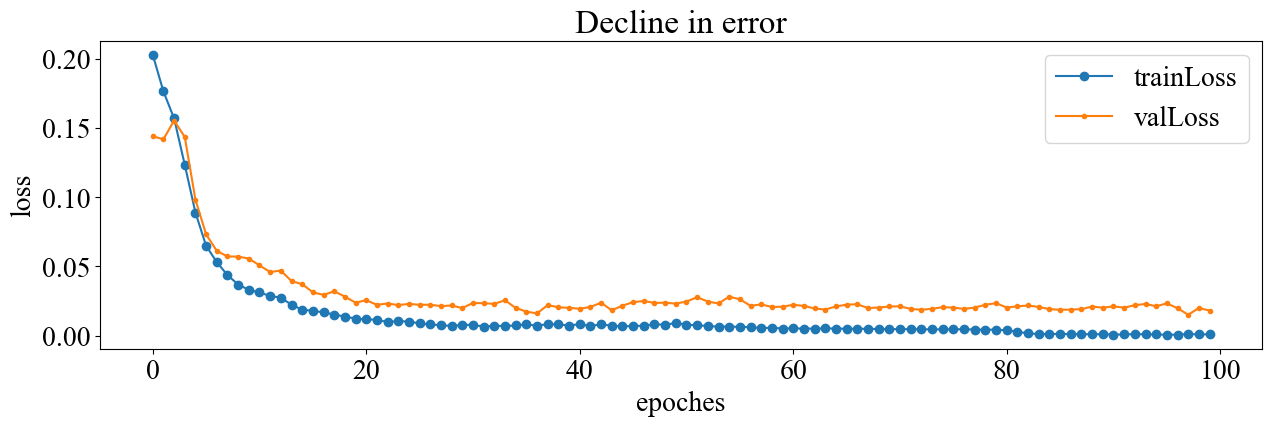

In [23]:
from torch import optim
import torch.nn as nn
import torch
from itertools import chain
 
def train_net(my_net,forward_net, device, epochs=100, batch_size=40, lr=0.002):  #batch_size越大，学习率lr越大；batch_size越大，精度越高，收敛越快。
    # Load training set
    #isbi_dataset = ISBI_Loader(data_path)
    train_loader = torch.utils.data.DataLoader(dataloader1,
                                               batch_size=batch_size, 
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=dataloader2,
                                              batch_size=batch_size,
                                              shuffle=True)
    
    optimizer = optim.AdamW(params=chain(my_net.parameters(),forward_net.parameters()), lr=lr)
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
    # Loss
    
    criterion = nn.L1Loss()
   
    
    # Initialize to positive infinity
    best_loss = float('inf')
    
    Train_loss_list = []
    Val_loss_list = []
    for epoch in range(epochs):
        
        my_net.train()
        

        for xtrain, ytrain in dataloader1:
            
            optimizer.zero_grad()
            #
            xtrain = xtrain.to(device=device, dtype=torch.float32)
            xtrain = xtrain.unsqueeze(1)

            ytrain = ytrain.to(device=device, dtype=torch.float32)
            ytrain = ytrain.unsqueeze(1)

            xtrain_nolabel = AT_nolabel.to(device=device, dtype=torch.float32)
#             
            
            ai_pred = my_net(xtrain)
            at_pred = forward_net(ytrain)
            ai_pred_nolabel = my_net(xtrain_nolabel)
            at_pred_nolabel = forward_net(ai_pred_nolabel)
            
            # Calculating loss
            loss_ai = criterion(ai_pred, ytrain)
            loss_at = criterion(at_pred, xtrain)
            loss_nolabel = criterion(at_pred_nolabel, xtrain_nolabel)
            loss=0.7*loss_ai+0.2*loss_at+0.1*loss_nolabel
            
            for xval,yval in dataloader2:
                xval = xval.to(device=device, dtype=torch.float32)
                xval = xval.unsqueeze(1)
                yval = yval.to(device=device, dtype=torch.float32)
                yval = yval.unsqueeze(1)
                yval_pred = my_net(xval)
                val_loss = criterion(yval_pred, yval)
            
            print('epoch',epoch,'Loss/train', loss.item(),'val_loss',val_loss.item())
            
            
            if loss < best_loss:
                best_loss = loss_ai*0.35+val_loss*0.65
                torch.save(my_net.state_dict(), 'inverse_model_2.pth')
            
            loss.backward(retain_graph=True)
            loss_ai.backward(retain_graph=True)
            loss_at.backward(retain_graph=True)
            loss_nolabel.backward()
            optimizer.step()
            
        Train_loss_list.append(loss.item())
        Val_loss_list.append(val_loss.item())
        

    x1 = np.arange(0, epochs)
    x2 = np.arange(0, epochs)
    y1 = Train_loss_list
    y2 = Val_loss_list
    y1=np.array(y1)
    y2=np.array(y2)
#     Loss = 0.35 * y1+ 0.65* y2
    plt.figure(figsize=(15,4))
    plt.plot(x1,y1,'o-',label='trainLoss')
    plt.title('Decline in error')
    plt.ylabel('loss')
    plt.plot(x2, y2,'.-',label='valLoss')
#    
    plt.legend(['trainLoss', 'valLoss', 'Loss = 0.35*trainLoss+0.65*valLoss'])
    plt.xlabel('epoches')
    
#     Loss_min=np.argmin(Loss)
    #y1_max=np.argmax(y1)
#     show_min='['+str(Loss_min)+' '+str(Loss[Loss_min])+']'
    #show_max='['+str(y1_max)+' '+str(y1[y1_max])+']'
    # 以●绘制最大值点和最小值点的位置
#     plt.scatter(Loss_min,Loss[Loss_min],color='c', marker='o', edgecolors='green', s=150) 

    plt.show()
 
if __name__ == "__main__":
    
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        my_net = inverse_model()
        forward_net = Forward(n_channels=1, n_classes=1)
        
        semi_inverse_net=my_net.to(device=device)
        forward_net=forward_net.to(device=device)
        
        train_net(my_net,forward_net, device)

In [24]:
pre_semi=semi_inverse_net(syn1.unsqueeze(1).float().to(device)).detach().cpu().squeeze()
print(pre_semi.shape)

torch.Size([720, 720])


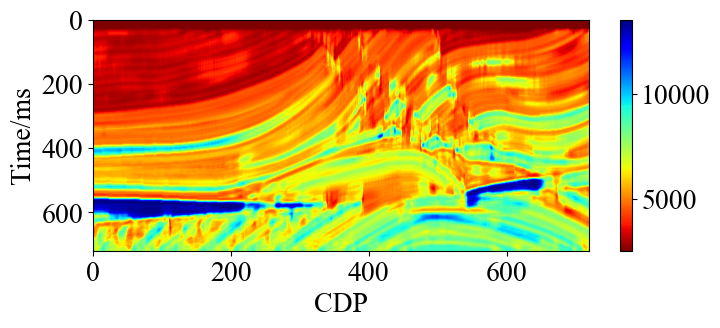

In [25]:
pre_semini=pre_semi*(PIH.max()-PIH.min())+PIH.min()
plt.figure(figsize=(8,3))
plt.imshow(pre_semini.T#,vmin=PIH1.min(),vmax=PIH1.max()
,aspect='auto',cmap='jet_r')
plt.ylim(720,0)
plt.xlabel('CDP')
plt.ylabel('Time/ms') 
plt.colorbar()
plt.savefig("pre_semi.T.svg", dpi=300,format="svg")
plt.show()

In [26]:
pre_syn=forward_net(PIH1.unsqueeze(1).float().to(device)).detach().cpu().squeeze()
pre_syn.shape

torch.Size([720, 720])

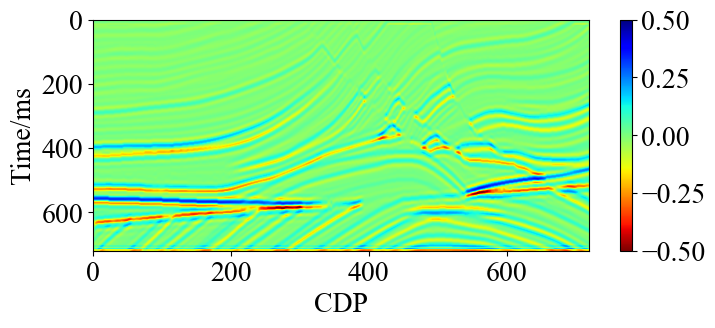

In [27]:
pre_synni=pre_syn*(syn.max()-syn.min())+syn.min() #Inverse normalization
plt.figure(figsize=(8,3))
plt.imshow(pre_synni.T#,vmin=PIH1.min(),vmax=PIH1.max()
,aspect='auto',cmap='jet_r',vmax=0.5,vmin=-0.5)
plt.ylim(720,0)
plt.xlabel('CDP')
plt.ylabel('Time/ms') 
plt.colorbar()
plt.savefig("pre_syn.T.svg", dpi=300,format="svg")
plt.show()

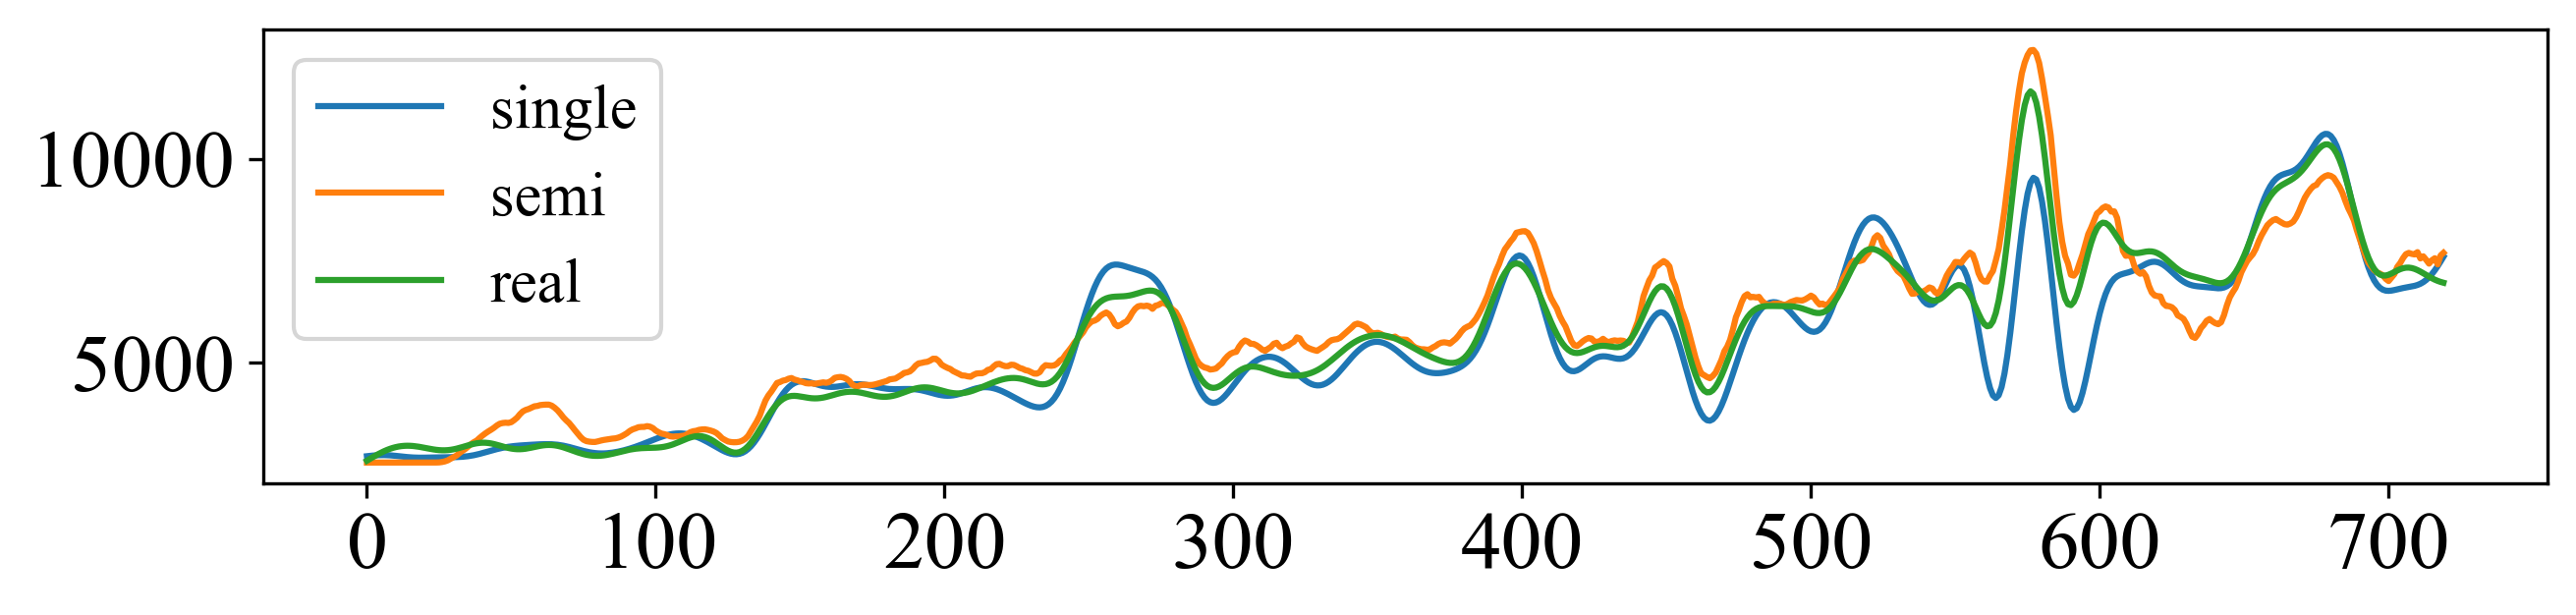

In [28]:
pre_test300= signal.filtfilt(b3, a3,pre_test[300,:])
plt.figure(figsize=(10,2),dpi=300)
plt.plot(pre_test300)
plt.plot(pre_semini[300,:])
plt.plot(PIH[300,:])
plt.legend(['single','semi','real'],fontsize=15)
plt.savefig("pre_301.T.svg", dpi=300,format="svg")
plt.show()

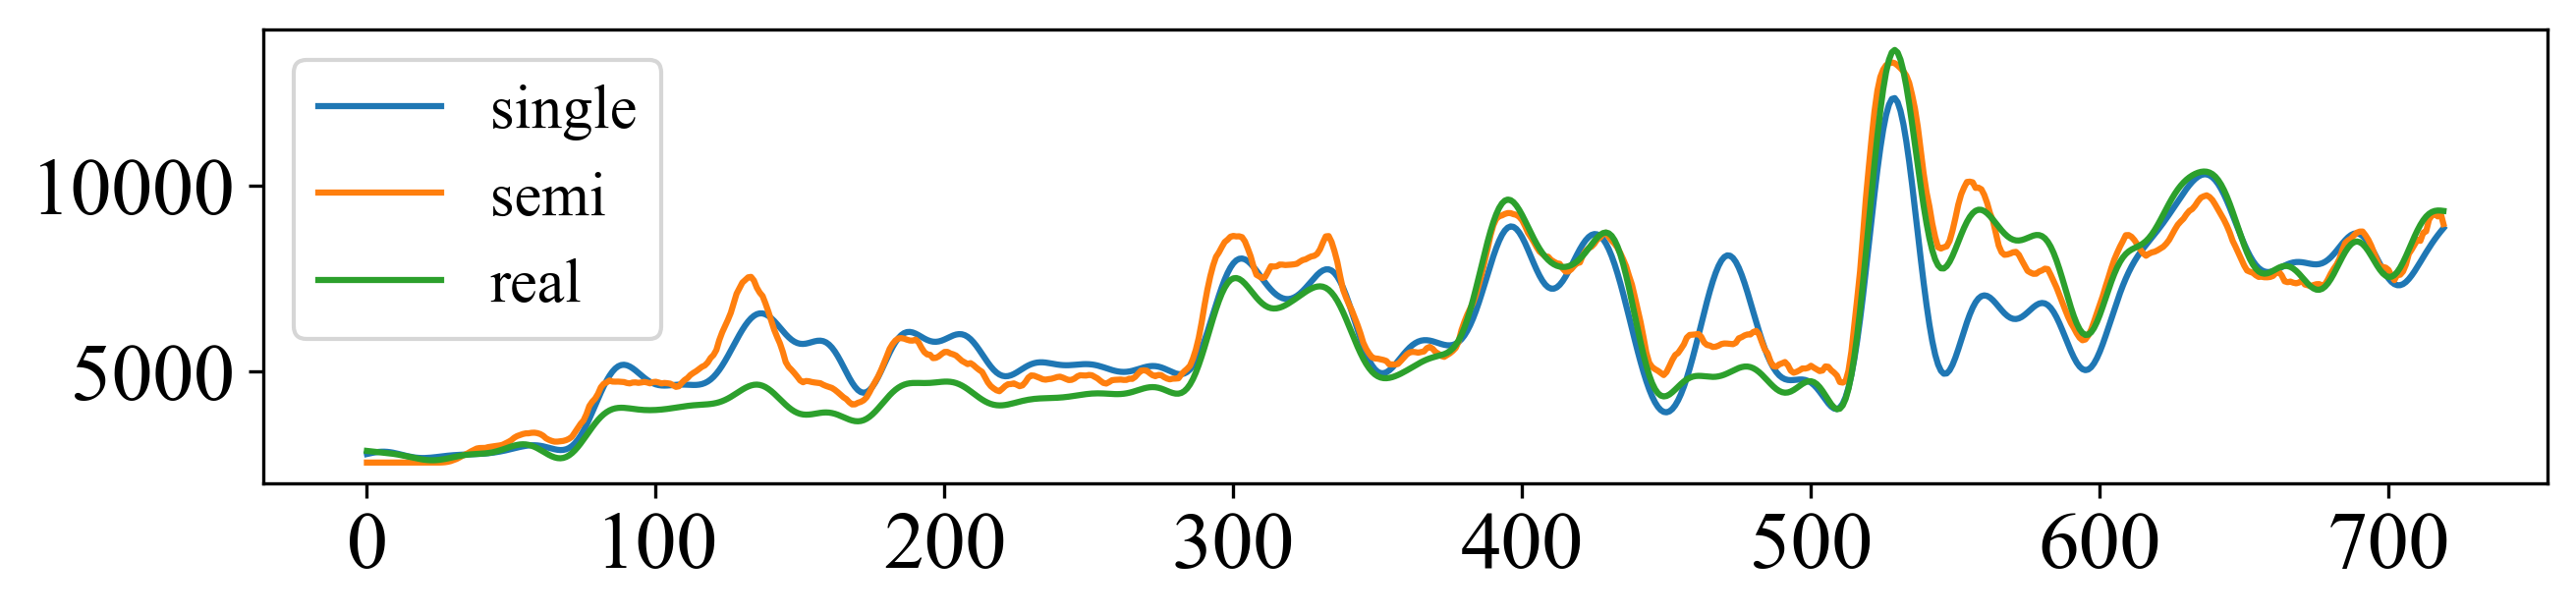

In [29]:
pre_test565= signal.filtfilt(b3, a3,pre_test[565,:])
plt.figure(figsize=(10,2),dpi=300)
plt.plot(pre_test565)
plt.plot(pre_semini[565,:])
plt.plot(PIH[565,:])
plt.legend(['single','semi','real'],fontsize=15)
plt.savefig("pre_566.T.svg", dpi=300,format="svg")
plt.show()

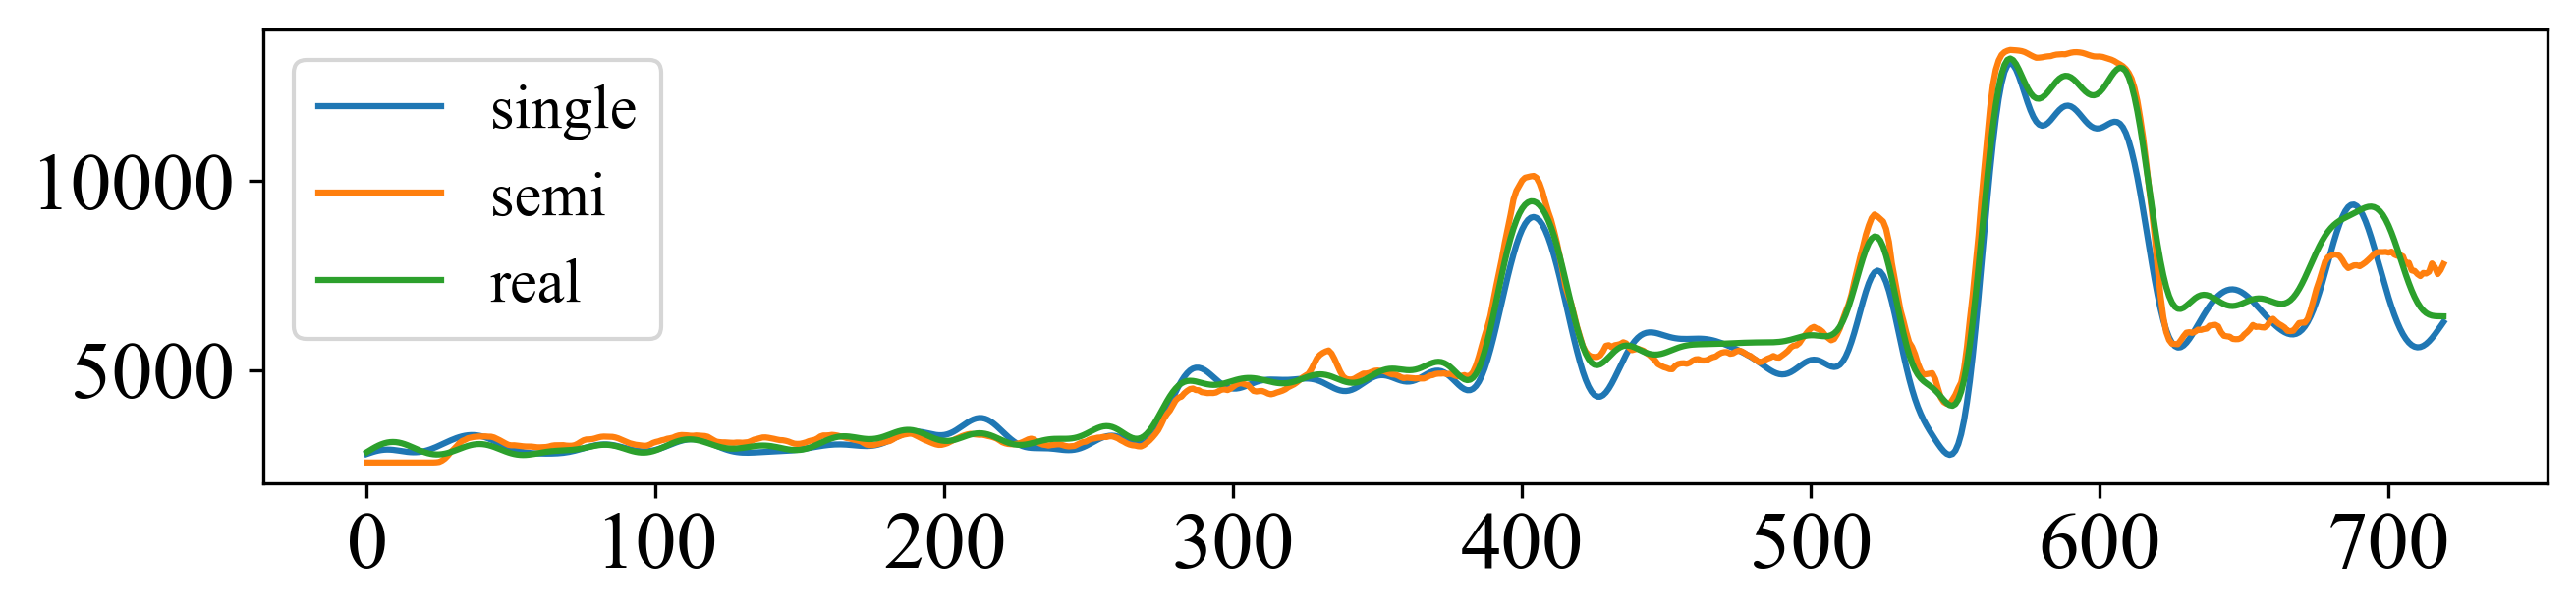

In [30]:

plt.figure(figsize=(10,2),dpi=300)
plt.plot(pre_test74)
plt.plot(pre_semini[74,:])
plt.plot(PIH[74,:])
plt.legend(['single','semi','real'],fontsize=15)
plt.savefig("pre_75.T.svg", dpi=300,format="svg")
plt.show()

In [31]:
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score

print('single.r2_score: %.3f'%r2_score(PIH[300,:],pre_test[300,:]),
     'semi.r2_score: %.3f'%r2_score(PIH[300,:],pre_semini[300,:]))
print('single.r2_score: %.3f'%r2_score(PIH[565,:],pre_test[565,:]),
     'semi.r2_score: %.3f'%r2_score(PIH[565,:],pre_semini[565,:]))
print('single.r2_score: %.3f'%r2_score(PIH[74,:],pre_test[74,:]),
      'semi.r2_score: %.3f'%r2_score(PIH[74,:],pre_semini[74,:]))
print('single.r2_score: %.3f'%r2_score(PIH.T,pre_test.T),
      'semi.r2_score: %.3f'%r2_score(PIH.T,pre_semini.T))

单监督r2_score: 0.876 半监督r2_score: 0.919
单监督r2_score: 0.792 半监督r2_score: 0.896
单监督r2_score: 0.947 半监督r2_score: 0.970
单监督r2_score: 0.768 半监督r2_score: 0.809


In [32]:
from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(PIH, pre_test)
rmse1 = np.sqrt(mse1)
print("single-supervised.rmse:",rmse1)

mse2 = mean_squared_error(PIH, pre_semini)
rmse2 = np.sqrt(mse2)
print("semi-supervised.rmse:",rmse2)

单监督rmse: 1044.243869353049
半监督rmse: 945.8088061378301


In [33]:
print('single-supervised.r2_score: %.3f'%r2_score(syn.T,pre_synni.T))

单监督r2_score: 0.745


In [34]:
mse3 = mean_squared_error(syn.T, pre_synni.T)
rmse3 = np.sqrt(mse3)
print("semi-supervised.rmse:",rmse3)

半监督rmse: 0.04085370435296264
